# Import libraries


In [20]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import io
np.set_printoptions(precision=15) #Sets precision


# Import data


In [12]:
from google.colab import files
datos = files.upload()


Saving trips_2023_10percent.csv to trips_2023_10percent.csv


Data Source The current notebook was performed on 10% of the original dataset, shortening overall runtime, subsampling by df.sample(frac=0.1, replace=False, random_state=1)

In [21]:
datos = pd.read_csv(io.BytesIO(datos['trips_2023_10percent.csv']))


# Helpful functions

In [15]:

def fecha_hora(df):
    ''' Splits "fecha_origen_recorrido" column into date and hour'''
    fecha_hora = df['fecha_origen_recorrido'].str.split(' ', expand=True)
    # Se almacena en un nuevo df
    fecha_hora.columns = ['Fecha','Hora']

    return fecha_hora

def obtener_dia_semana(fecha):
    '''Gets weekday name'''
    return datetime.datetime.strptime(fecha,'%Y-%m-%d').weekday()

def nombre_dia(df):
    '''Gets weekday name based on the number of the day'''
    dia = df.replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
    return dia

def momento_dia_fc(x):
    '''Moment of the day conversion'''
    if (x['hora_del_dia']>= '06:00:00') & (x['hora_del_dia']<= '12:00:00'):
        return '1.Morning'

    if (x['hora_del_dia']>='12:00:00') & (x['hora_del_dia'] <= '14:00:00'):
        return '2.Mid-day'

    if (x['hora_del_dia']>='14:00:00') & (x['hora_del_dia'] <= '19:00:00'):
        return '3.Afternoon'

    if (x['hora_del_dia']>'19:00:00') & (x['hora_del_dia'] <= '24:00:00'):
        return '4.Night'

    if (x['hora_del_dia']>'00:00:00') & (x['hora_del_dia'] < '06:00:00'):
        return '5.Early morning'


# Data wrangling and processing

In [22]:
datos.rename(columns={"género": "genero"}, inplace=True)#Rename colmns

#Change comma by dot
datos['duracion_recorrido'] = datos['duracion_recorrido'].str.replace(',', '.')
datos['duracion_recorrido'] = datos['duracion_recorrido'] .astype('str').str.replace(r".", r"", regex=False)

#Use dict to convert data types
convert_dict = {'duracion_recorrido': float,
                'long_estacion_origen':float,
                'lat_estacion_origen':float,
                'long_estacion_destino':float,
                'lat_estacion_destino':float
                }
datos = datos.astype(convert_dict)

#Rename column to be more specific
datos.rename(columns={"duracion_recorrido": "duracion_recorrido_segs"}, inplace=True)
datos['duracion_min'] = datos['duracion_recorrido_segs'] / 60

#Keep rows with reasonable time trip duration
trip_limit = 60*3 #mins
datos = datos.loc[datos['duracion_min']< trip_limit]


#Check & treat NaNs, null values or empty cells (string, '').
datos.isna().sum().sum()
datos = datos.dropna()
datos.isnull().values.any() #No null values

#Split date and hour at beggining of trip
tiempo = fecha_hora(datos)

#Obtain weekday from trip's starting date
weekday_number = tiempo.Fecha.map(obtener_dia_semana)
datos['dia_de_la_semana'] = nombre_dia(weekday_number)

#Obtain moment of the day from trip's starting date
datos['hora_del_dia'] = tiempo.Hora
datos['momento_dia'] = datos.apply(lambda x: momento_dia_fc(x),1)

#Calculate distances using haversine method.
lon1, lat1, lon2, lat2 = map(np.radians, [datos["long_estacion_origen"],
                                          datos["lat_estacion_origen"],
                                          datos["long_estacion_destino"],
                                          datos["lat_estacion_destino"]]) #np.deg2rad(180) = np.radians
newlon = lon2 - lon1
newlat = lat2 - lat1

haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
dist = 2 * np.arcsin(np.sqrt(haver_formula))
Rearth = 6367 #6367 for distance in KM; for miles use 3958
km = Rearth * dist
datos['dist_km'] =  km


#Check if there are trips in which the bike was returned to the same station, and
#delete them
sum(datos['dist_km']==0)
datos = datos.loc[datos['dist_km'] !=0 ]

 # 1) Top 10 stations used as check in / out

[Text(0.5, 36.72222222222221, 'Count'),
 Text(301.8244949494949, 0.5, 'Station name (check in)')]

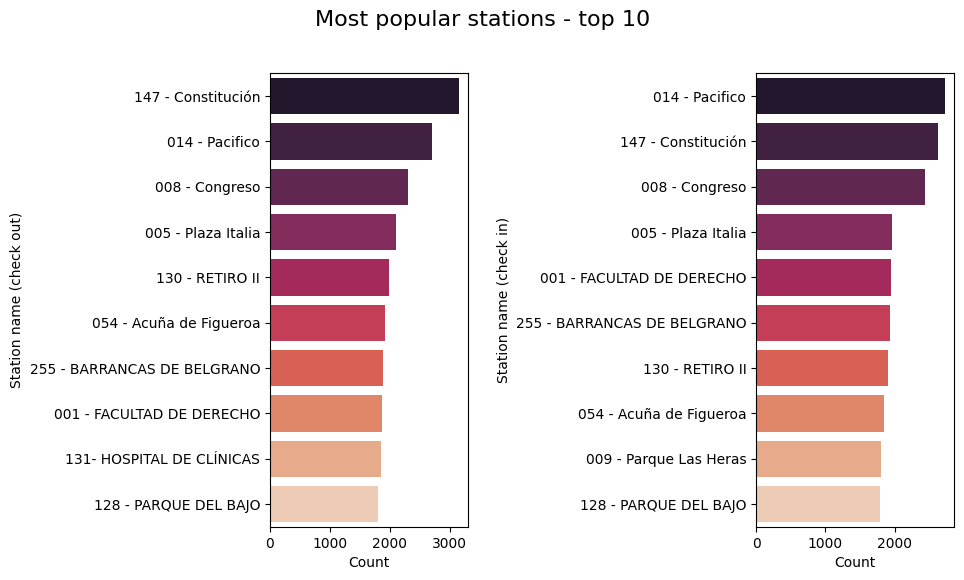

In [23]:
top_outs =  datos['nombre_estacion_origen'].value_counts()[:10].reset_index()
top_outs.rename(columns = {'index':'station', 'nombre_estacion_origen':'count_station'}, inplace=True)
top_ins =  datos['nombre_estacion_destino'].value_counts()[:10].reset_index()
top_ins.rename(columns = {'index':'station', 'nombre_estacion_destino':'count_station'}, inplace=True)


fig, axes = plt.subplots(1,2, figsize=(10,6), squeeze=False)
fig.suptitle('Most popular stations - top 10', size=16)
sns.barplot(ax = axes[0,0], x=top_outs.count_station, y=top_outs.station,  orient="h", palette = ("rocket") )
sns.barplot(ax = axes[0,1], x=top_ins.count_station, y=top_ins.station,  orient="h", palette = ("rocket") )
plt.tight_layout(pad=2)
axes[0,0].set(xlabel='Count',  ylabel='Station name (check out)')
axes[0,1].set(xlabel='Count',  ylabel='Station name (check in)')

